In [12]:
%load_ext autoreload
%autoreload 2
import timeit
import pickle
import numpy as np
import matplotlib.pyplot as plt
from shape import Shape, Block, plot_hulls
from convex_hulls_graph import HullGraph
from shapely.geometry import Point, Polygon
from shapely.affinity import rotate
import shapely.ops as ops
from shape_boat import ShapeBoat, ShapeBoat_spline, check_vertex_constraints
%autoreload 2
from shapeshift_trajectory import shapeshift_trajectory

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Composing Shapes from Blocks

In [13]:

shape_a = Shape([Block(-0.75,0.5,90),Block(0,0.25,0),Block(1,0.25,0),Block(1.75,.5,90)])
shape_b = Shape([Block(0,0)])#,Block(1,0.25),Block(0,-0.25)])
shape_c = Shape([Block(1.0,0.25)])

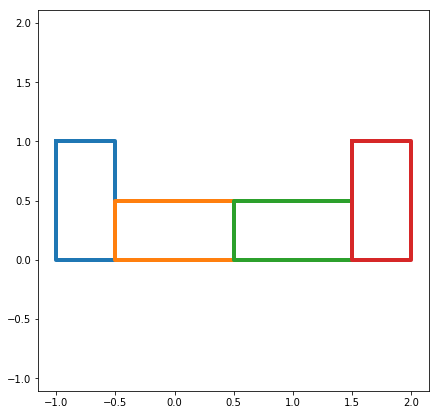

In [14]:
shape_a.plot(union=False)

### Partitioning of convex hulls around shape

In [15]:
msums, hulls = shape_a.c_space_rotate(shape_b)
#plot_hulls(hulls, text=False)

### C-Space of a given obstacle b

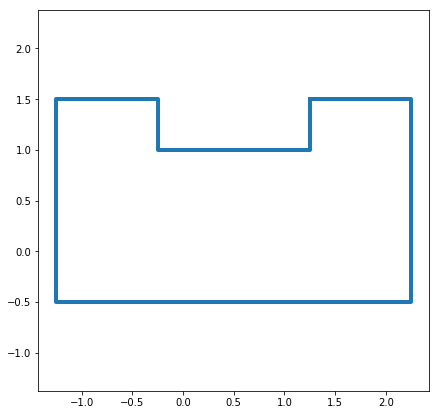

In [16]:
shape_a.plot_polygons([msums.values()[0]])

### Finding Convex Hull of C-Space

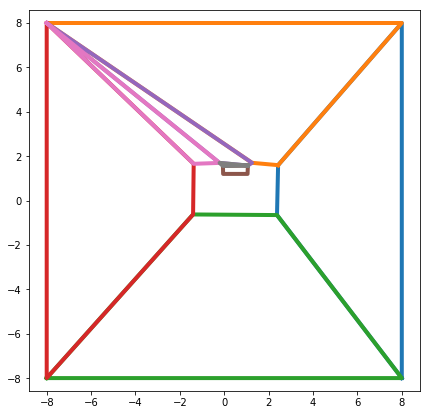

In [17]:
shape_a.plot_polygons(hulls.values()[0])

## Trajectory Planning

### MIQP - b-splines

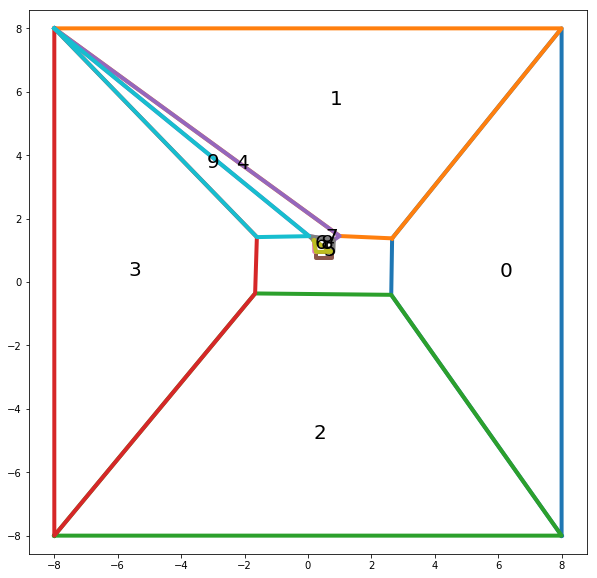

finding_vertex POINT (-1.5 0.5) 180.0
finding_vertex POINT (0.5 0.75) 0.0
found path endpoint hulls 26 35
6
INITIALIZED 1 ShapeBoat_spline boats
boats_S:(1, 16, 8), boats_U:(1, 15, 3), time_array:(16,)
Number of decision vars 277
0.002068 seconds
ADDING COSTS
0.007779 seconds
ADDING CONSTRAINTS
opt_hull True
0.152316 seconds
PLANNING
SolutionResult.kSolutionFound
2.664567 seconds

INITIALIZED 1 ShapeBoat_spline boats
boats_S:(1, 16, 8), boats_U:(1, 15, 3), time_array:(16,)
Number of decision vars 173
0.002791 seconds
ADDING COSTS
0.000920 seconds
ADDING CONSTRAINTS
opt_hull False
0.113144 seconds
PLANNING
SolutionResult.kSolutionFound
0.013292 seconds



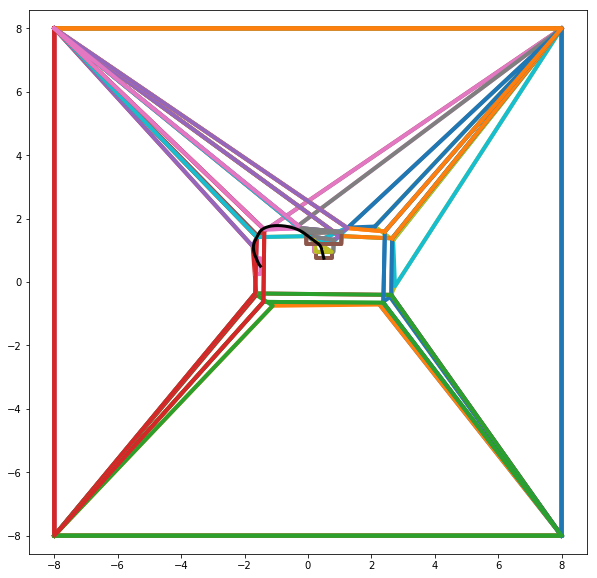

In [18]:
tests = {'past': [[-5., 0., 0.], [-5., 0., 0.]], \
         'around1': [[-1.5, 0.5, 180], [2.5, 0.5, 180]], \
         'around2': [[-1.5, 0.5, 180], [0.5, 0.75, 0]]}

test = 'around2'

results = shapeshift_trajectory(shape_b, shape_a, *tests[test], N=15, opt_angle=True)

if results['success']:
    boats_S = results['S_knots']
    boats_S_new = results['S']
    boat = results['boat']    
    plt.figure(figsize=(10,10))
    plot_hulls([x for a in boat.hulls.values() for x in a], (boats_S_new[0,:,0], boats_S_new[0,:,1]), text=False, figure=False)
    #plt.plot(boats_S_new[0,:,0], boats_S_new[0,:,1], color='red', linewidth='4')
    plt.show()

### Show polytope graph from plan

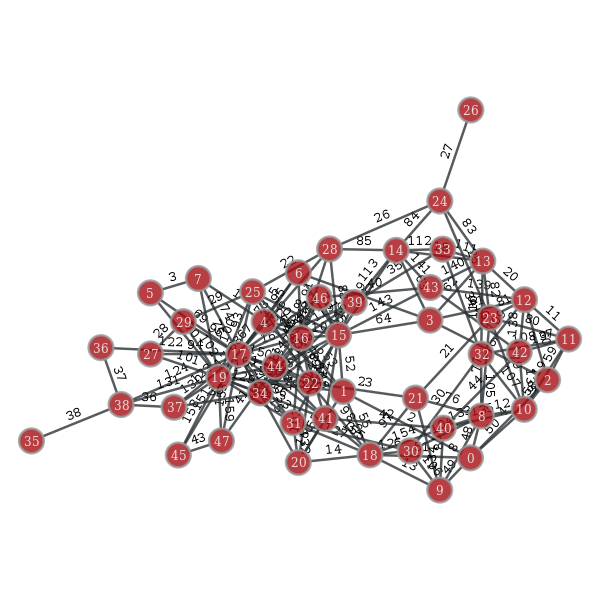

In [19]:
boat.g.draw_graph()

### Show Path with hulls that were used

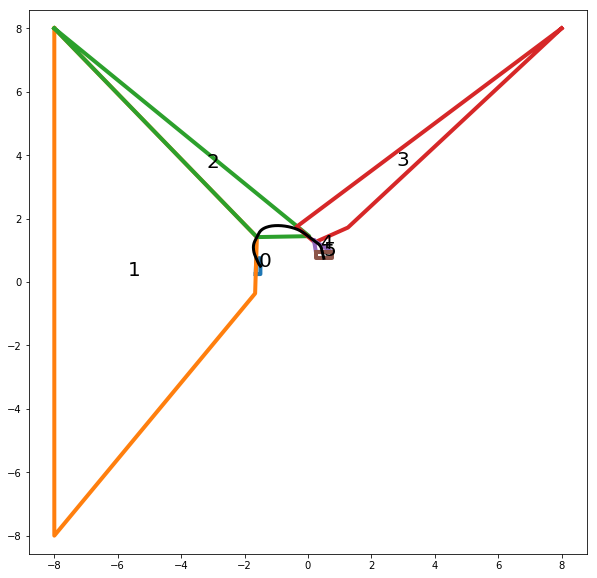

In [20]:
plot_hulls([x['polygon'] for x in boat.hull_path],(boats_S_new[0,:,0], boats_S_new[0,:,1]))